# Image Classifier

### Introduction
Pneumonia is a condition where the lungs become inflamed and infected. It happens when germs, such as bacteria or viruses, invade the air sacs in the lungs. These air sacs are responsible for exchanging oxygen and carbon dioxide during breathing. When pneumonia occurs, these air sacs fill up with fluid, pus, and cells that fight infection, making it difficult for the lungs to work properly.

a fully connected network would not be appropriate for image recognition due to the lack of translation invariance, as well as the inconvenience of having to train a network with so many weights.
### Setup and Load data

In [92]:
!pip install tensorflow
!pip install opencv-python

In [93]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
anyio                        3.5.0
appdirs                      1.4.4
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        22.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
Bottleneck                   1.3.5
brotlipy                     0.7.0
cachetools                   5.3.1
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           2.0.4
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.0.5
cryptography                 39.0.1
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.1
defusedxml                   0.7.1
en

In [94]:
import tensorflow as tf
import os #navegate through documents

In [95]:
#This code snippet is used to avoid Out-Of-Memory (OOM) errors when working with TensorFlow and GPUs. OOM errors occur when the GPU memory is insufficient to handle the computational tasks, leading to crashes or failures during the execution of the program.
gpus = tf.config.experimental.list_physical_devices('GPU') #retrieves a list of available physical GPUs
for gpu in gpus: #Limiting memory growth
    tf.config.experimental.set_memory_growth(gpu, True) #allows the GPU memory allocation to grow dynamically as needed, rather than allocating all the memory upfront.

In [96]:
import cv2 
import imghdr

In [97]:
data_dir_train = '../Data_sets/ImageClassifier/chest_xray/train'
data_dir_test = '../Data_sets/ImageClassifier/chest_xray/test'
data_dir_val = '../Data_sets/ImageClassifier/chest_xray/val'
img_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [98]:
os.listdir(data_dir_train) #Go to files
os.listdir(os.path.join(data_dir_train, 'NORMAL')) #Access to each image
len(os.listdir(os.path.join(data_dir_train,  'NORMAL')))

1341

### Remove dodgy images

In [99]:
def remove_dodgy(data_dir, extensions):
    for img_type in os.listdir(data_dir):#Go to files
        for image in os.listdir(os.path.join(data_dir, img_type)): #Access to each image
            path = os.path.join(data_dir, img_type, image) #Return path for 'image'
            try: #Read image
                img = cv2.imread(path)
                tip = imghdr.what(path) #extract format of image in path
                if tip not in extensions:
                    print('Image have different extension {}'.forma(path))
                    os.rmove(path) #Delete it
            except Exception as e:
                print('Issue with image {}'.format(path))

In [100]:
remove_dodgy(data_dir_train, img_extensions)
remove_dodgy(data_dir_test, img_extensions)
remove_dodgy(data_dir_val, img_extensions)

In [101]:
tf.data.Dataset #represents a sequence of elements, where each element can be a single data point or a batch of data points. It is a powerful tool for building efficient and scalable input pipelines (a pipeline refers to a sequence of operations applied to a dataset to prepare and preprocess the data for training or inference) for machine learning models.

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [102]:
import numpy as np
from matplotlib import pyplot as plt

In [103]:
data = tf.keras.utils.image_dataset_from_directory(data_dir_train) #create a TensorFlow dataset from a directory of image files
#Resize iages, shuffle, etc

Found 5216 files belonging to 2 classes.


In [104]:
data.class_names

['NORMAL', 'PNEUMONIA']

Class Names: ['NORMAL', 'PNEUMONIA']
Label 0 Class: NORMAL
Label 1 Class: PNEUMONIA


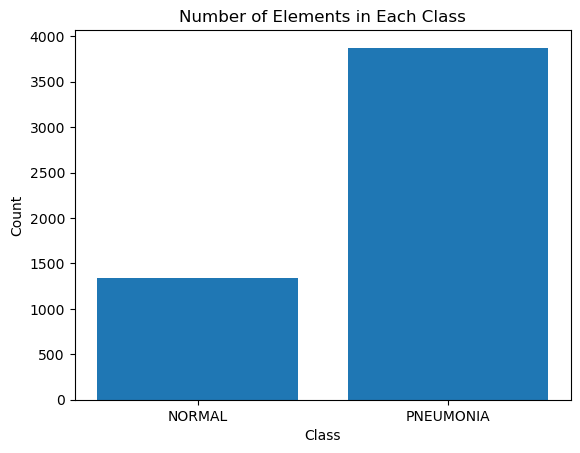

In [105]:
import matplotlib.pyplot as plt

class_names = data.class_names
print("Class Names:", class_names)
print("Label 0 Class:", class_names[0])
print("Label 1 Class:", class_names[1])

class_counts = {class_name: 0 for class_name in class_names}

# Iterate over the dataset and count occurrences of each class
for images, labels in data:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

# Plot the number of elements in each class
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Elements in Each Class')
plt.show()

In [106]:
#iterator as numpy array
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [107]:
batch[1] # label

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1])

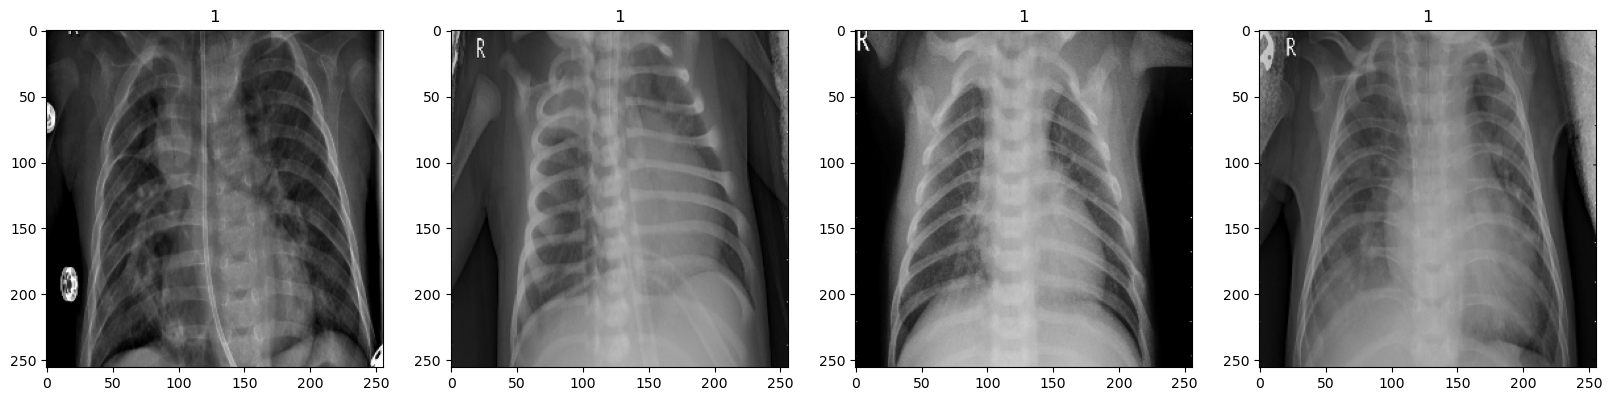

In [108]:
#To know the label, let's to plot
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][0:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])

# 1 pneumonia, 0 normal 

### Preprocess
#### Scale data

In [109]:
batch[0].shape

(32, 256, 256, 3)

In [110]:
#Data values between 0 and 1
data = data.map(lambda x, y: (x/255, y)) # x images, y target variable

In [111]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
print(f' Min value: {batch[0].min()}, Max value: { batch[0].max()}')

 Min value: 0.0, Max value: 1.0


#### Split data
Because the dataset is already split, I do it in this way

In [113]:
test = tf.keras.utils.image_dataset_from_directory(data_dir_test)
test = test.map(lambda x, y: (x/255, y))
val = tf.keras.utils.image_dataset_from_directory(data_dir_val)
val = val.map(lambda x, y: (x/255, y))

Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


### Deep model

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [115]:
model = Sequential() # linear stack of layers

In [116]:
#model.add(Conv2D(# of filters, (siz of the filter in pixels), numer of pixel to tralate (dx), activation='relu', input_shape(image_size)))
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3) ) )
model.add(MaxPooling2D()) # It reduces the spatial dimensions (width and height) of the input data, thus reducing the number of parameters and computational complexity in subsequent layers.
#reduce the spatial dimensions of the data, helping to extract and retain important features while improving computational efficiency.

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #transform multidimensional input data into a one-dimensional vector, to prepare the data for fully connected layers 
#Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #sigmoid because we eant 0 or 1

In [117]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy']) #prepares the model for training

In [118]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0


### Train

In [120]:
logdir = './logs/Pneumonia' # directory where the logs for TensorBoard will be saved.

In [121]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # creates a TensorBoard used to enable the integration of TensorBoard with the training process

In [122]:
hist = model.fit(data, epochs=20, validation_data=val, callbacks=[tensorboard_callback]) # starts the training process

Epoch 1/20
163/163 [==============================] - 353s 2s/step - loss: 0.2258 - accuracy: 0.9059 - val_loss: 0.6723 - val_accuracy: 0.6875
Epoch 2/20
163/163 [==============================] - 234s 1s/step - loss: 0.1129 - accuracy: 0.9565 - val_loss: 0.3648 - val_accuracy: 0.7500
Epoch 3/20
163/163 [==============================] - 232s 1s/step - loss: 0.0761 - accuracy: 0.9730 - val_loss: 0.0681 - val_accuracy: 1.0000
Epoch 4/20
163/163 [==============================] - 225s 1s/step - loss: 0.0587 - accuracy: 0.9801 - val_loss: 0.7095 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 241s 1s/step - loss: 0.0503 - accuracy: 0.9816 - val_loss: 0.1008 - val_accuracy: 0.9375
Epoch 6/20
163/163 [==============================] - 267s 2s/step - loss: 0.0324 - accuracy: 0.9895 - val_loss: 0.3376 - val_accuracy: 0.8125
Epoch 7/20
163/163 [==============================] - 258s 2s/step - loss: 0.0233 - accuracy: 0.9921 - val_loss: 0.0313 - val_accuracy: 1.0000

### Performance

In [123]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


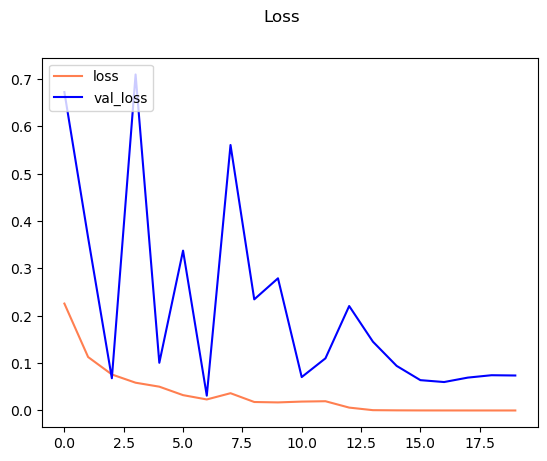

In [124]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='coral', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=12)
plt.legend(loc="upper left")
plt.show()

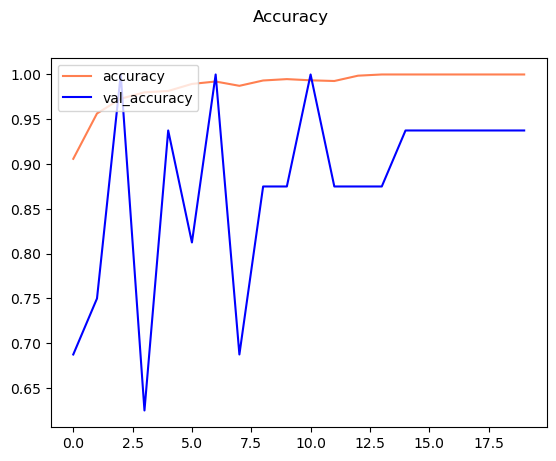

In [125]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='coral', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=12)
plt.legend(loc="upper left")
plt.show()

In [126]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [127]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 7s 7s/step


In [128]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7054545283317566, Recall: 0.9948717951774597, Accuracy: 0.7371794581413269


### Test

# make for to proof all the image test

In [130]:
from tensorflow.keras.models import save_model
save_model(model, 'models/Pneumoniaclassifier')  # Save model in native Keras format

INFO:tensorflow:Assets written to: models/Pneumoniaclassifier\assets


INFO:tensorflow:Assets written to: models/Pneumoniaclassifier\assets


In [143]:
new_model = load_model('./models/Pneumoniaclassifier.h5')
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

if yhatnew < 0.5: 
    print(f'Predicted class is normal')
else:
    print(f'Predicted class is not normal')

1/1 [==============================] - 0s 193ms/step
Predicted class is Happy
